In [24]:
from utils import *
# from param import *
from skimage import measure
from scipy import ndimage as ndi
import pandas as pd

In [4]:
image_path = '/Volumes/BiomedML/Projects/QuPath_projects/Covid19/0419_Detection_100c/Images/'
qupath_output = '/Volumes/BiomedML/Projects/QuPath_projects/Covid19/0419_Detection_100c/Blue/'
# round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
dapi_1 = os.path.join(image_path, '2021_Covid19_ref_images.jpg')

In [5]:
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
pil_img_dapi1 = Image.fromarray(img_dapi1)
dapi1_gray = pil_img_dapi1.convert('L')
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)

In [8]:
img_dapi1.shape

(5620, 5979, 3)

(-0.5, 5978.5, 5619.5, -0.5)

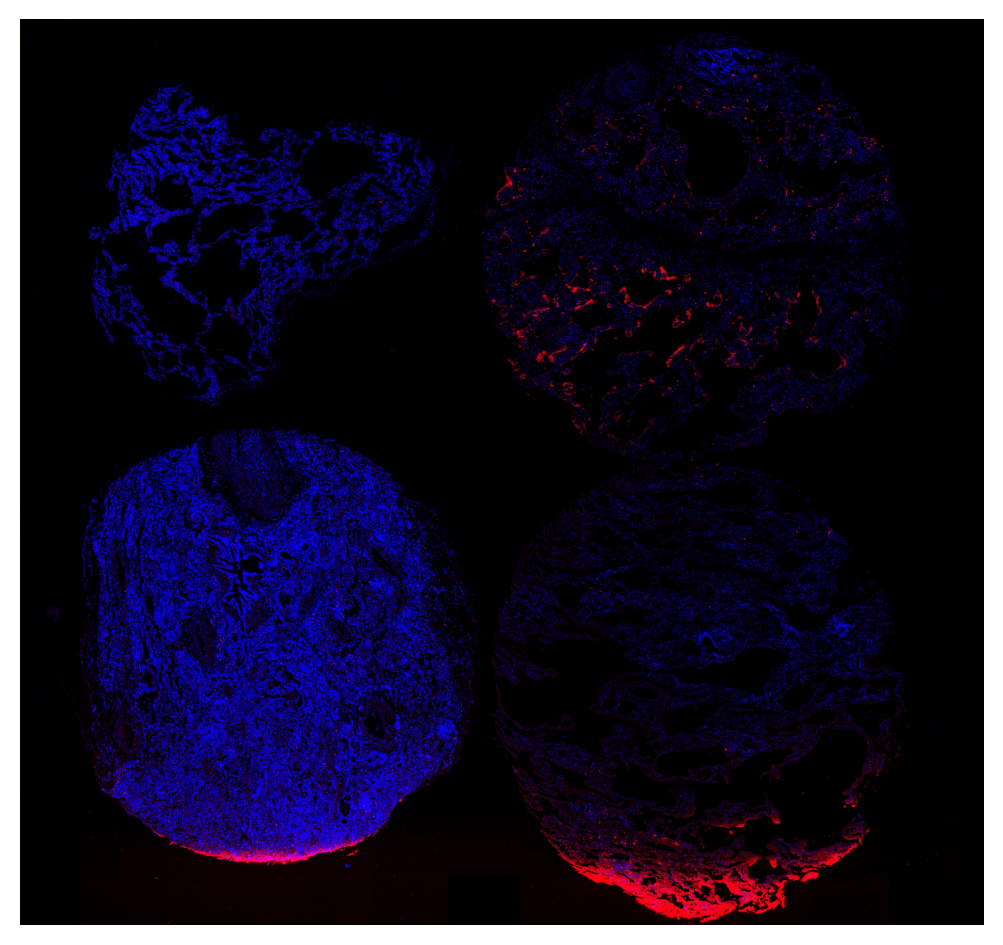

In [7]:
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(img_dapi1)
plt.axis('off')

In [9]:
scene1_output_dir = os.path.join(qupath_output)
list_output_files1 = get_files_in_dir_recursively(scene1_output_dir, 'tsv')
print(len(list_output_files1))
list_output_files1 = np.array(list_output_files1)

1860


In [12]:
11240/2

5620.0

In [13]:
original_tiff_size = (11240,11958)

In [14]:
img_dapi1.shape

(5620, 5979, 3)

In [16]:
re.findall('x(\d+)_y(\d+)_w(\d+)_h(\d+)', 'Covid19_channel_measurement_values_x4483_y5795_w186_h175.tsv')

[('4483', '5795', '186', '175')]

In [29]:
demo_df = pd.read_csv('/Volumes/BiomedML/Projects/QuPath_projects/Covid19/0419_Detection_100c/Blue/Covid19_channel_measurement_values_x4483_y5795_w186_h175.tsv', sep='\t')
demo_df['Cell: Red mean'].mean()

9.876144943820226

In [18]:
def get_xywh_from_fn(fn):
    """ parse file name to extract rectangle coordinates
    fn: filename string
    """
    results = re.findall('x(\d+)_y(\d+)_w(\d+)_h(\d+)', fn)
    if len(results) == 1:
        x_coord, y_coord, width, height = results[0]
        x_coord, y_coord = int(x_coord), int(y_coord)
        width, height =  int(width), int(height)
        return x_coord, y_coord, width, height
    else:
        Exception('Check')
#         return x_coord, y_coord, [list_to_int(element) for element in results[:-1]]



In [20]:
all_rects = list()
recorded_parent_boxes = list()
for fn in list_output_files1:
    if 'Covid19' in fn:
        x_coord, y_coord, width, height = get_xywh_from_fn(fn)
        annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                   (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                   original_tiff_size)
        annot_width, annot_height = convert_original2scaled(width, height, 
                                                   (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                   original_tiff_size)
        rect = [annot_x, annot_y, 
                annot_x + annot_width,
                annot_y + annot_height]

        all_rects.append(rect)

1860


(-0.5, 5978.5, 5619.5, -0.5)

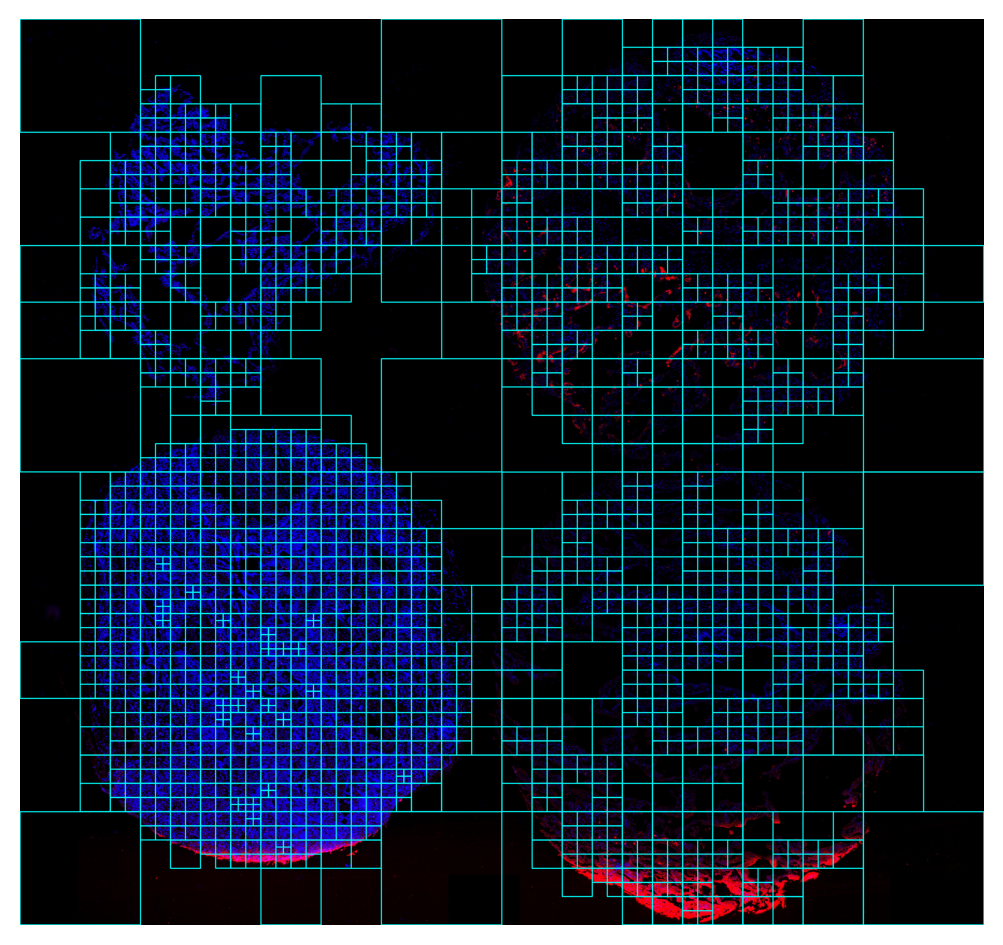

In [23]:
demo_image = draw_rectangles(img_dapi1, all_rects, thickness=6)
print(len(all_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(demo_image, vmax=255, vmin=0)
plt.axis('off')

### Visualize Covid signal for each box 

In [72]:
all_score_rects = list()
areas = list()
box_scores = list()
child_count = dict()

for fn in list_output_files1:
    if 'Covid19' in fn:
        x_coord, y_coord, width, height = get_xywh_from_fn(fn)
        annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                   (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                   original_tiff_size)
        annot_width, annot_height = convert_original2scaled(width, height, 
                                                   (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                   original_tiff_size)
        areas.append(annot_width*annot_height)
        rect = [annot_x, annot_y, 
                annot_x + annot_width,
                annot_y + annot_height]
        # grab only the window that cells are detected
        if annot_width*annot_height < 130923:
            tmp_df = pd.read_csv(fn, sep='\t')
            score = tmp_df['Cell: Red mean'].mean() / tmp_df['Cell: Blue mean'].mean()
            if annot_y > 4500 and score > 3 :
                all_score_rects.append(rect)
                box_scores.append(3)
                continue
            else:
                box_scores.append(score)
                all_score_rects.append(rect)


box_scores = np.array(box_scores)
heat_colors = np.array(map_heat_values2colors(box_scores))

heat_colors = heat_colors * 255

heat_demo_image2 = draw_rectangles_heat(np.zeros_like(img_dapi1), all_score_rects, heat_colors, box_scores)
 

0.02051021519878957 3.0


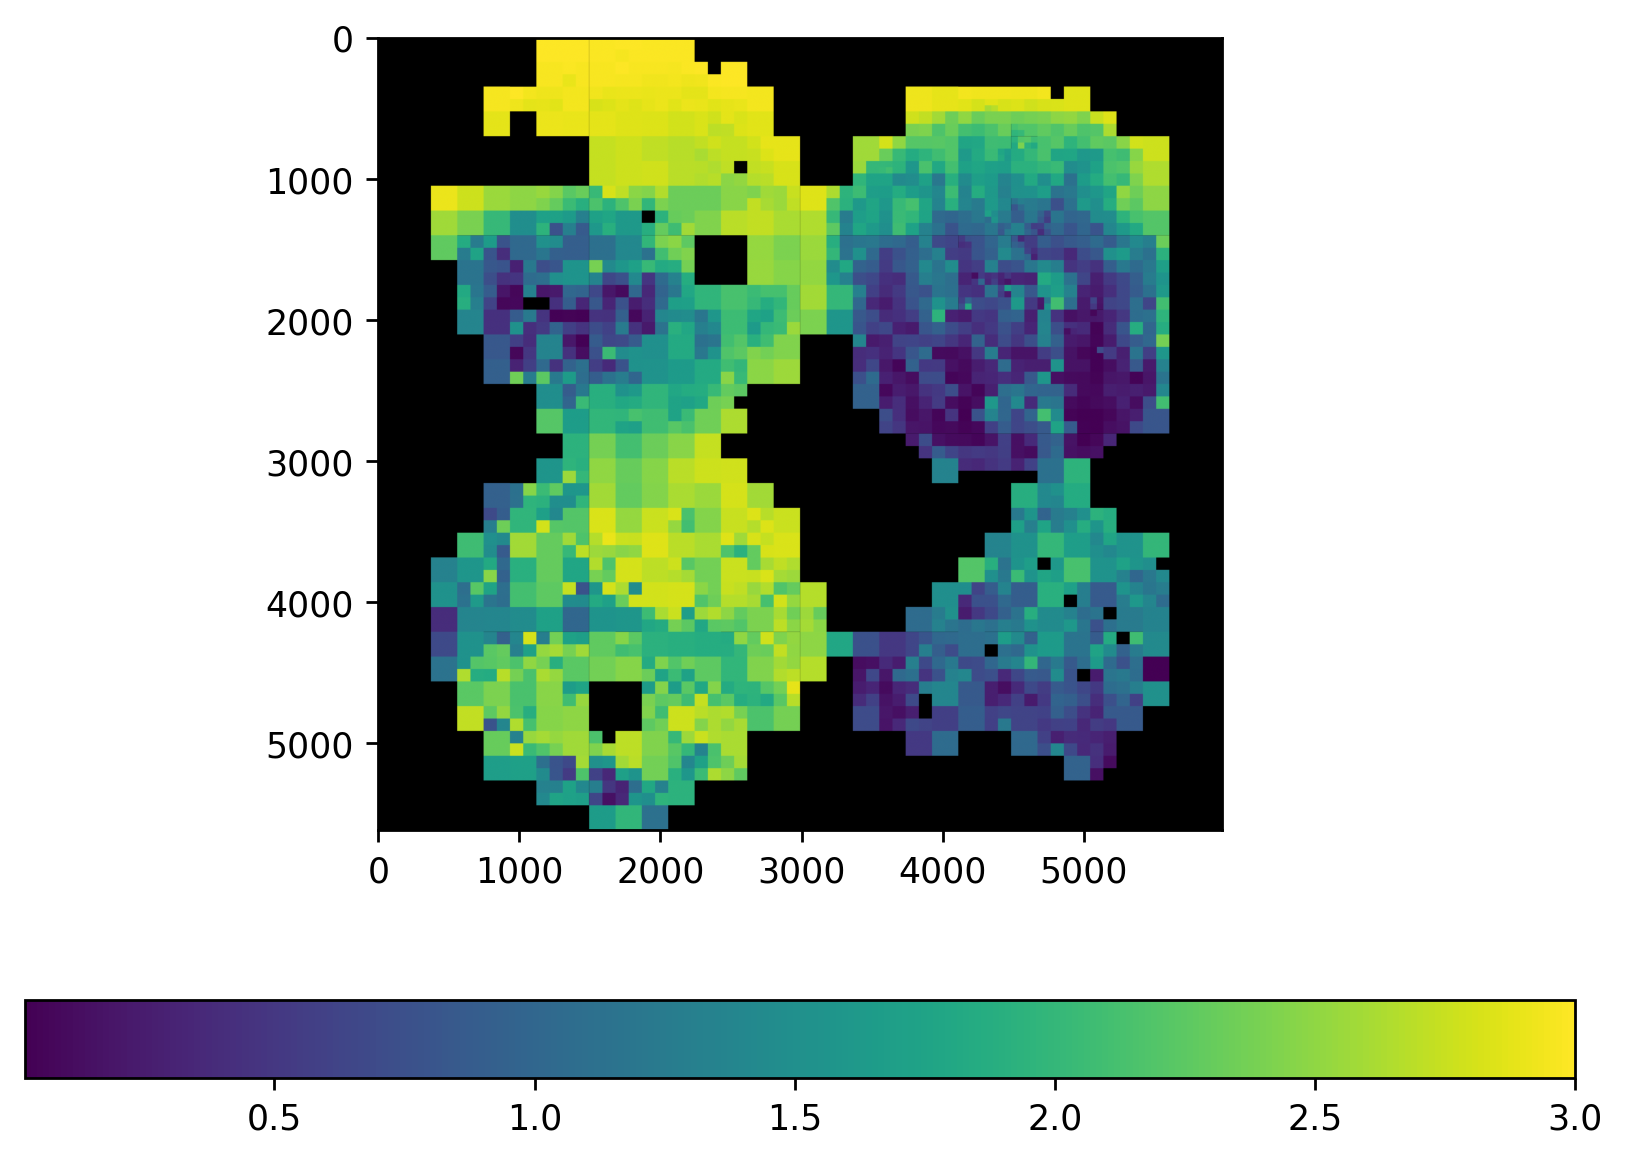

In [73]:
print(box_scores.min(), box_scores.max())
new_rotated_heat_demo_image2 = rotate(heat_demo_image2, 180, resize=True)
plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(new_rotated_heat_demo_image2, vmax=box_scores.min(), vmin=box_scores.max())
plt.colorbar(orientation='horizontal')
# plt.savefig('Covid_heatmap_of_covid_infected_level_normalised.png')

In [65]:
tmp_df

,Image,Centroid X px,Centroid Y px,Nucleus: Area,Nucleus: Red mean,Nucleus: Blue mean,Cell: Red mean,Cell: Blue mean
0,0416_tissue_hires_4.tif,3277.5,10276.2,96,84.2727,243.9697,84.2727,243.9697
1,0416_tissue_hires_4.tif,3326.9,10282.3,231,62.0000,246.8319,62.0000,246.8319
2,0416_tissue_hires_4.tif,3350.5,10276.8,73,57.5676,201.2568,57.5676,201.2568
3,0416_tissue_hires_4.tif,3298.9,10278.9,59,65.1270,242.9841,65.1270,242.9841
4,0416_tissue_hires_4.tif,3289.9,10282.1,46,165.8936,241.7872,165.8936,241.7872
5,0416_tissue_hires_4.tif,3343.0,10288.3,69,52.1268,189.0704,52.1268,189.0704
6,0416_tissue_hires_4.tif,3272.9,10293.6,78,75.9286,228.8333,75.9286,228.8333
7,0416_tissue_hires_4.tif,3282.4,10289.2,24,91.4615,181.2308,91.4615,181.2308
8,0416_tissue_hires_4.tif,3291.5,10292.4,46,63.5400,193.1400,63.5400,193.1400
9,0416_tissue_hires_4.tif,3342.6,10298.0,46,57.1373,154.7255,57.1373,154.7255
